In [278]:
import pandas as pd
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
import torch                    
import pyro
import pyro.distributions as dist
import numpy as np

In [279]:
dfranking = pd.read_csv("dfranking.csv")
dfplayerpergame = pd.read_csv("dfplayerpergame.csv")
dfgames = pd.read_csv("dfgames.csv")
dfgamebox = pd.read_csv("dfgamebox.csv")

In [280]:
S = dfgames["SEASON"].unique()
M = dfgames
GB = dfgamebox

In [281]:
np.unique(M["VISITOR_TEAM_ID"].values)

array([1610612737, 1610612738, 1610612739, 1610612740, 1610612741,
       1610612742, 1610612743, 1610612744, 1610612745, 1610612746,
       1610612747, 1610612748, 1610612749, 1610612750, 1610612751,
       1610612752, 1610612753, 1610612754, 1610612755, 1610612756,
       1610612757, 1610612758, 1610612759, 1610612760, 1610612761,
       1610612762, 1610612763, 1610612764, 1610612765, 1610612766])

In [282]:
#           #LAL        #GSW        #DEN      #PHX
teams = [1610612747, 1610612744, 1610612743, 1610612756]

In [283]:
M = M[(M["HOME_TEAM_ID"].isin(teams)) & (M["VISITOR_TEAM_ID"].isin(teams))]
GB = GB[GB["GAME_ID"].isin(M["GAME_ID"])]

In [284]:
GB["PTS"] = (GB["FG3M"]*3 + GB["FTM"] + (GB["FGM"]-GB["FG3M"])*2)
GB = GB[["MIN", "PTS", "TEAM_ID", "GAME_ID", "PLAYER_NAME"]]

/tmp/ipykernel_17414/251064421.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GB["PTS"] = (GB["FG3M"]*3 + GB["FTM"] + (GB["FGM"]-GB["FG3M"])*2)


In [285]:
GB.head()

,MIN,PTS,TEAM_ID,GAME_ID,PLAYER_NAME
620,30.11,16.0,1610612747,22200459,Lonnie Walker IV
621,21.01,3.0,1610612747,22200459,Troy Brown Jr.
622,26.30,16.0,1610612747,22200459,Thomas Bryant
623,23.09,9.0,1610612747,22200459,Patrick Beverley
624,29.11,30.0,1610612747,22200459,Dennis Schroder


In [286]:
dfplayerpergame["PTSPRMIN"] = (dfplayerpergame["FG3M"]*3 + dfplayerpergame["FTM"] + (dfplayerpergame["FGM"]-dfplayerpergame["FG3M"])*2) / dfplayerpergame["MIN"]
bins = [-np.inf, 7, 15, np.inf]
labels = [1, 2, 3]
dfplayerpergame['MINS_level'] = pd.cut(dfplayerpergame['MIN'], bins=bins, labels=labels).astype(int)
dfplayerpergame = dfplayerpergame.fillna(0)
dfplayerpergame = dfplayerpergame[["PLAYER_NAME", "POS","AGE","EXP","PTSPRMIN", "SEASON", "MINS_level"]]


In [287]:
dummies = pd.get_dummies(dfplayerpergame['MINS_level']).astype(int)
dfplayerpergame = pd.concat([dfplayerpergame, dummies], axis=1)

In [288]:
dfplayerpergame.head()

,PLAYER_NAME,POS,AGE,EXP,PTSPRMIN,SEASON,MINS_level,1,2,3
0,Aaron Gordon,PF,23.0,5.0,0.473373,2019,3,0,0,1
1,Aaron Holiday,PG,22.0,1.0,0.457364,2019,2,0,1,0
2,Aaron Nesmith,0,22.0,0.0,0.000000,2019,1,1,0,0
3,Abdel Nader,SF,25.0,2.0,0.342105,2019,2,0,1,0
4,Adam Mokoka,0,22.0,0.0,0.000000,2019,1,1,0,0


In [289]:
Y = {s: M[M["SEASON"] == s] for s in S}
GB_dict = {s: {} for s in S}
M_id_dict = {s: {} for s in S}

In [290]:
Y[s]["GAME_ID"].values

array([42000234, 42000233, 42000232, 42000231, 42000156, 42000155,
       42000154, 42000153, 42000152, 42000151, 52000121, 22001039,
       22001024, 22000982, 22000903, 22000821, 22000651, 22000608,
       22000185, 22000542, 22000527, 22000416, 22000341, 22000286,
       22000248, 22000238, 22000212, 22000177])

In [291]:
GB[GB["GAME_ID"].isin(Y[s]["GAME_ID"])]["PLAYER_NAME"].unique()

array(['Mikal Bridges', 'Jae Crowder', 'Deandre Ayton', 'Devin Booker',
       'Chris Paul', 'Cameron Johnson', 'Cameron Payne', 'Torrey Craig',
       'Dario Saric', 'Ty-Shon Alexander', 'Jevon Carter',
       'Langston Galloway', 'Frank Kaminsky', "E'Twaun Moore",
       'Jalen Smith', 'Michael Porter Jr.', 'Aaron Gordon',
       'Nikola Jokic', 'Will Barton', 'Monte Morris', 'Austin Rivers',
       'Facundo Campazzo', 'JaMychal Green', 'JaVale McGee',
       'Shaquille Harrison', 'Bol Bol', 'Vlatko Cancar', 'Markus Howard',
       'Paul Millsap', 'Zeke Nnaji', 'LeBron James', 'Anthony Davis',
       'Marc Gasol', 'Kentavious Caldwell-Pope', 'Dennis Schroder',
       'Kyle Kuzma', 'Montrezl Harrell', 'Alex Caruso', 'Wesley Matthews',
       'Talen Horton-Tucker', 'Markieff Morris', 'Jared Dudley',
       'Alfonzo McKinnie', 'Ben McLemore', 'Andre Drummond',
       'Devontae Cacok', 'Andrew Wiggins', 'Draymond Green',
       'Kevon Looney', 'Kent Bazemore', 'Stephen Curry',
       'Ju

In [292]:
Y = {s: M[M["SEASON"] == s] for s in S}
GB_dict = {s: {} for s in S}
M_id_dict = {s: {} for s in S}
name_dict = {s: GB[GB["GAME_ID"].isin(Y[s]["GAME_ID"])]["PLAYER_NAME"].unique() for s in S}
for s in S:
    GB_dict[s] = {g: GB[GB["GAME_ID"] == g] for g in M[M["SEASON"] == s]["GAME_ID"].unique()}
playerstats_dict = {s: [] for s in S}

In [293]:
for s in S:
    playerstats_dict[s] = dfplayerpergame[(dfplayerpergame["SEASON"] == s-1) & dfplayerpergame["PLAYER_NAME"].isin(name_dict[s])]
    name_dict[s] = playerstats_dict[s].pop("PLAYER_NAME").values
    playerstats_dict[s] = torch.from_numpy(playerstats_dict[s].drop(["POS","SEASON", "MINS_level"],axis=1).values).float()
    Y[s]["P_a_gr_b"] = (Y[s]["PTS_home"] / (Y[s]["PTS_home"] / Y[s]["PTS_away"]))
    M_id_dict[s] = Y[s][["GAME_ID","HOME_TEAM_ID","VISITOR_TEAM_ID"]].values
    Y[s] = torch.from_numpy(Y[s][["PTS_home", "PTS_away", "HOME_TEAM_WIN_PCT", "AWAY_TEAM_WIN_PCT", "HOME_TEAM_K", "AWAY_TEAM_K"]].values)

/tmp/ipykernel_17414/2986768630.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y[s]["P_a_gr_b"] = (Y[s]["PTS_home"] / (Y[s]["PTS_home"] / Y[s]["PTS_away"]))
/tmp/ipykernel_17414/2986768630.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y[s]["P_a_gr_b"] = (Y[s]["PTS_home"] / (Y[s]["PTS_home"] / Y[s]["PTS_away"]))
/tmp/ipykernel_17414/2986768630.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [294]:
for s in S:
    print(f"season: {s}, num_players_stats: {len(playerstats_dict[s])}, num_players_names: {len(name_dict[s])}")

season: 2022, num_players_stats: 54, num_players_names: 54
season: 2021, num_players_stats: 77, num_players_names: 77
season: 2020, num_players_stats: 72, num_players_names: 72


In [312]:
def model(playerstats_dict, Y, S, M_id_dict, GB_dict, name_dict,s):
    it=0
    #data indexing
    probs = []
    num_players = len(name_dict[s])
    num_matches = len(M_id_dict[s])

    #sigma = pyro.sample("sigma", dist.HalfCauchy(0.5))
    probs = []
    with pyro.plate(f'{s}_playerweights', num_players):
            bias_p = pyro.sample(f"bias_{s}", dist.Normal(torch.zeros(num_players), 1))
            w_p = pyro.sample(f"w_{s}", dist.Normal(torch.zeros(num_players), 1))

    with pyro.plate(f'{s}_matches', num_matches):

        #mu_ta = torch.tensor((M_dict[s]["HOME_TEAM_WIN_PCT"] + M_dict[s]["AWAY_TEAM_WIN_PCT"]).values,dtype=torch.float) #implement NN
        #mu_tb = torch.tensor((M_dict[s]["HOME_TEAM_WIN_PCT"] - M_dict[s]["AWAY_TEAM_WIN_PCT"]).values,dtype=torch.float)
        
        #sigma_tensor = sigma.expand_as(mu_ta)

        ka = pyro.sample(f"ka_{s}", dist.Normal(torch.zeros(num_matches), 20*torch.ones(num_matches)), obs=Y[s][:,4])
        kb = pyro.sample(f"kb_{s}", dist.Normal(torch.zeros(num_matches), 20*torch.ones(num_matches)), obs=Y[s][:,4])
        
    
    for idx in range(num_matches):

        game_id = M_id_dict[s][idx,0]
        home_id = M_id_dict[s][idx,1]
        away_id = M_id_dict[s][idx,2]
        GB = GB_dict[s][game_id]

        # Getting indicies
        players_ta = set(GB[GB["TEAM_ID"] == home_id]["PLAYER_NAME"])
        players_tb = set(GB[GB["TEAM_ID"] == away_id]["PLAYER_NAME"])
        players_idx_ta = [i for i, value in enumerate(name_dict[s]) if value in players_ta]
        players_idx_tb = [i for i, value in enumerate(name_dict[s]) if value in players_tb]
        GB_ta_idx = np.where(GB["TEAM_ID"] == home_id)
        GB_tb_idx = np.where(GB["TEAM_ID"] == away_id)
        with pyro.plate(f'{game_id}_box_ta', len(GB_ta_idx[0])): #
                mins_ta = pyro.sample(f'mins_{s}_{game_id}_ta', dist.Normal(bias_p[players_idx_ta] + w_p[players_idx_ta] *ka[idx], torch.ones(len(GB_ta_idx[0]))), obs=torch.from_numpy(GB.iloc[GB_ta_idx]["MIN"].values))
                pts_ta = pyro.sample(f'pts_{s}_{game_id}_ta', dist.Poisson(torch.exp(mins_ta * playerstats_dict[s][players_idx_ta,2])), 
                                    obs = torch.from_numpy(GB.iloc[GB_ta_idx]["PTS"].values))

        with pyro.plate(f'{game_id}_box_tb', len(GB_tb_idx[0])): #
                mins_tb = pyro.sample(f'mins_{s}_{game_id}_tb', dist.Normal(bias_p[players_idx_tb] + w_p[players_idx_tb] *kb[idx], torch.ones(len(GB_tb_idx[0]))), obs=torch.from_numpy(GB.iloc[GB_tb_idx]["MIN"].values))
                pts_tb = pyro.sample(f'pts_{s}_{game_id}_tb', dist.Poisson(torch.exp(mins_tb * playerstats_dict[s][players_idx_tb,2])), 
                                    obs = torch.from_numpy(GB.iloc[GB_tb_idx]["PTS"].values))



        Pts_ta = torch.sum(pts_ta)
        Pts_tb = torch.sum(pts_tb)

        P_ta_gt_tb = Pts_ta / (Pts_ta + Pts_tb)
        probs.append(P_ta_gt_tb)
    return probs


In [313]:
# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=70, warmup_steps=10, num_chains=1)
mcmc.run(playerstats_dict, Y, S, M_id_dict, GB_dict, name_dict,2020)

# Show summary of inference results
mcmc.summary()

Sample:  66%|██████▋   | 53/80 [11:17, 72.08s/it, step size=3.22e-03, acc. prob=0.637]

In [37]:
from matplotlib import pyplot as plt
import seaborn as sns

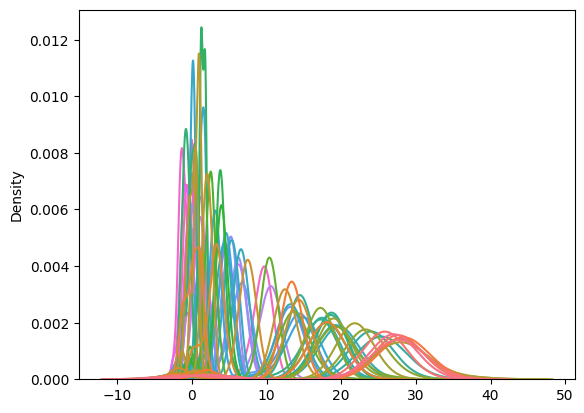

In [41]:
# Extract samples from posterior
posterior_samples = mcmc.get_samples()

sns.kdeplot(posterior_samples["bias_2020"])
plt.legend([],[], frameon=False)
#sns.kdeplot(posterior_samples["w_2022"])


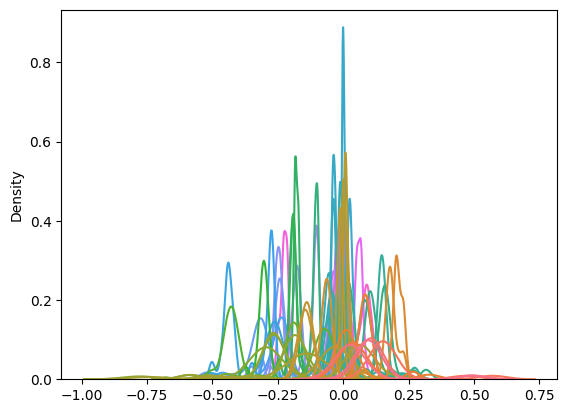

In [43]:
sns.kdeplot(posterior_samples["w_2020"])
plt.legend([],[], frameon=False)

In [201]:
Y[2022]
# ["PTS_home", "PTS_away", "HOME_TEAM_WIN_PCT", "AWAY_TEAM_WIN_PCT", "HOME_TEAM_K", "AWAY_TEAM_K"]

array([[130.        , 104.        ,   0.613     ,   0.433     ,
          5.96666667,  -3.53333333],
       [126.        , 108.        ,   0.429     ,   0.607     ,
         31.36666667,  -3.23333333],
       [115.        , 105.        ,   0.647     ,   0.313     ,
          0.96666667,   7.86666667],
       [130.        , 119.        ,   0.643     ,   0.4       ,
          0.96666667, -36.91      ]])

In [16]:
#STANDARDIZE K SCORES
mean = Y[2022][:,4:].mean(axis=0)
std = Y[2022][:,4:].std(axis=0)
Y[2022][:,4:] = (Y[2022][:,4:] - mean) / std

In [247]:
def model(playerstats_dict, Y, S, M_id_dict, GB_dict, name_dict,s):
    it = 0
    #data indexing
    probs = []
    n_cat = 3
    level_players = playerstats_dict[s][:,3:]
    num_players = len(name_dict[s])
    num_matches = len(M_id_dict[s])

    #draw global sigma for k
    sigma = pyro.sample("sigma", dist.HalfCauchy(0.5))
    
    #Draw mean vector for weights
    w_mu = pyro.sample(f"w_mu_{s}", dist.Normal(torch.zeros(n_cat), 
                                                       torch.ones(n_cat)).to_event()) # Prior for the weight mean
    #Draw sd vector for weights
    w_sigma  = pyro.sample(f"w_sigma_{s}",  dist.HalfCauchy(torch.ones(n_cat)).to_event()) # Prior for the weight standard deviation
    
    bias_p  = pyro.sample(f"bias_{s}", dist.Normal(torch.zeros(num_players), 
                                            10*torch.ones(num_players)).to_event()) # Draw individual priors for the bias
    
    with pyro.plate(f'levelweights_{s}', 3):
            w_p = pyro.sample(f"w_{s}", dist.Normal(w_mu, w_sigma))
            w_p = torch.matmul(level_players,w_p)
    with pyro.plate(f'{s}_matches', num_matches):

                 #HOME_WINPCT  #AWAY_WINPCT
        mu_ta = (Y[s][:,2] / Y[s][:,3]) #TODO: implement NN
                 #AWAY_WINPCT  #HOME_WINPCT
        mu_tb = (Y[s][:,3] / Y[s][:,2])
        
        sigma_tensor = sigma.expand_as(mu_ta)

        ka = pyro.sample(f"ka_{s}", dist.Normal(mu_ta, sigma_tensor).to_event(), obs=Y[s][:,4])
        kb = pyro.sample(f"kb_{s}", dist.Normal(mu_tb, sigma_tensor).to_event(), obs=Y[s][:,5])

    for idx in range(num_matches):
        game_id = M_id_dict[s][idx,0]
        home_id = M_id_dict[s][idx,1]
        away_id = M_id_dict[s][idx,2]
        GB = GB_dict[s][game_id]

        #Grabbing indicies from name_dict and boxscore (GB)
        players_ta = set(GB[GB["TEAM_ID"] == home_id]["PLAYER_NAME"])
        players_tb = set(GB[GB["TEAM_ID"] == away_id]["PLAYER_NAME"])
        players_idx_ta = [i for i, value in enumerate(name_dict[s]) if value in players_ta]
        players_idx_tb = [i for i, value in enumerate(name_dict[s]) if value in players_tb]
        GB_ta_idx = np.where(GB["TEAM_ID"].values == home_id)
        GB_tb_idx = np.where(GB["TEAM_ID"].values == away_id)
             
        with pyro.plate(f'{game_id}_box_ta', len(GB_ta_idx[0])): # #Exponential dist 
                lambda_rate_ta = bias_p[players_idx_ta] + w_p[players_idx_ta] *ka[idx]
                mins_ta = pyro.sample(f'mins_{s}_{game_id}_ta', dist.Exponential(lambda_rate_ta), obs=torch.from_numpy(GB.iloc[GB_ta_idx]["MIN"].values))
                pts_ta = pyro.sample(f'pts_{s}_{game_id}_ta', dist.Poisson(mins_ta * playerstats_dict[s][players_idx_ta,2]), 
                                    obs = torch.from_numpy(GB.iloc[GB_ta_idx]["PTS"].values))

        with pyro.plate(f'{game_id}_box_tb', len(GB_tb_idx[0])): #
                lambda_rate_tb = bias_p[players_idx_tb] + w_p[players_idx_tb] *kb[idx]
                mins_tb = pyro.sample(f'mins_{s}_{game_id}_tb', dist.Exponential(lambda_rate_tb), obs=torch.from_numpy(GB.iloc[GB_tb_idx]["MIN"].values))
                pts_tb = pyro.sample(f'pts_{s}_{game_id}_tb', dist.Poisson(mins_tb * playerstats_dict[s][players_idx_tb,2]), 
                                    obs = torch.from_numpy(GB.iloc[GB_tb_idx]["PTS"].values))

        Pts_ta = torch.sum(pts_ta)
        Pts_tb = torch.sum(pts_tb)

        P_ta_gt_tb = Pts_ta / (Pts_ta + Pts_tb)
        probs.append(P_ta_gt_tb)
        it += 1
        #print(it)
    return probs


In [248]:
# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=70, warmup_steps=10, num_chains=1)
mcmc.run(playerstats_dict, Y, S, M_id_dict, GB_dict, name_dict,2020)

# Show summary of inference results
mcmc.summary()

Warmup:   0%|          | 0/80 [00:00, ?it/s]

ValueError: Model specification seems incorrect - cannot find valid initial params.

In [44]:
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

In [54]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

n_steps = 14000

# Setup the optimizer
adam_params = {"lr": 0.001} # learning rate (lr) of optimizer
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

In [56]:
# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(S, M_dict, GB_dict, playerpermin_dict, Players_dict,2020)
    if step % 100 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

/tmp/ipykernel_31037/2735485520.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pts_ta = pyro.sample(f'pts_{s}_{game_id}_ta', dist.Poisson(torch.exp(mins_ta * torch.tensor(playerpermin_dict[s][players_idx_ta]))),
/tmp/ipykernel_31037/2735485520.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pts_tb = pyro.sample(f'pts_{s}_{game_id}_tb', dist.Poisson(torch.exp(mins_tb * torch.tensor(playerpermin_dict[s][players_idx_tb]))),


[0] ELBO: 2692101677120966.5
[100] ELBO: 2692101677019441.0
[200] ELBO: 2692101676969494.0
[300] ELBO: 2692101676940118.5
[400] ELBO: 2692101676924249.5
[500] ELBO: 2692101676880449.5
[600] ELBO: 2692101676874941.0
[700] ELBO: 2692101676864653.5
[800] ELBO: 2692101676857421.5
[900] ELBO: 2692101676857368.0
[1000] ELBO: 2692101676851469.0
[1100] ELBO: 2692101676850655.0
[1200] ELBO: 2692101676851219.5
[1300] ELBO: 2692101676849722.0
[1400] ELBO: 2692101676851059.5
[1500] ELBO: 2692101676848636.0
[1600] ELBO: 2692101676848292.5
[1700] ELBO: 2692101676848008.5
[1800] ELBO: 2692101676846586.5
[1900] ELBO: 2692101676846840.0
[2000] ELBO: 2692101676846123.5
[2100] ELBO: 2692101676845898.0
[2200] ELBO: 2692101676845668.0
[2300] ELBO: 2692101676845217.0
[2400] ELBO: 2692101676844877.0
[2500] ELBO: 2692101676844577.0
[2600] ELBO: 2692101676844295.0
[2700] ELBO: 2692101676843823.5
[2800] ELBO: 2692101676843632.5
[2900] ELBO: 2692101676843317.5
[3000] ELBO: 2692101676843055.5
[3100] ELBO: 2692101

In [57]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("bias_2020","w_2020", "ka_2020","kb_2020"))
samples = predictive(S, M_dict, GB_dict, playerpermin_dict, Players_dict,2022)

/tmp/ipykernel_31037/2735485520.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pts_ta = pyro.sample(f'pts_{s}_{game_id}_ta', dist.Poisson(torch.exp(mins_ta * torch.tensor(playerpermin_dict[s][players_idx_ta]))),
/tmp/ipykernel_31037/2735485520.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pts_tb = pyro.sample(f'pts_{s}_{game_id}_tb', dist.Poisson(torch.exp(mins_tb * torch.tensor(playerpermin_dict[s][players_idx_tb]))),


In [58]:
samples

{}

In [59]:
bias_samples = samples["bias_2020"].detach().numpy()
w_samples = samples["w_2020"].detach().numpy()
ka_samples = samples["ka_2020"].detach().numpy()
kb_samples = samples["kb_2020"].detach().numpy()

KeyError: 'bias_2020'

In [20]:
import matplotlib.pyplot as plt

In [31]:
import seaborn as sns

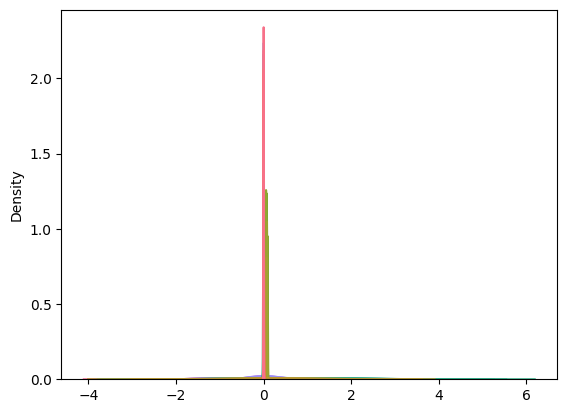

In [34]:
sns.kdeplot(w_samples)
plt.legend([],[], frameon=False)

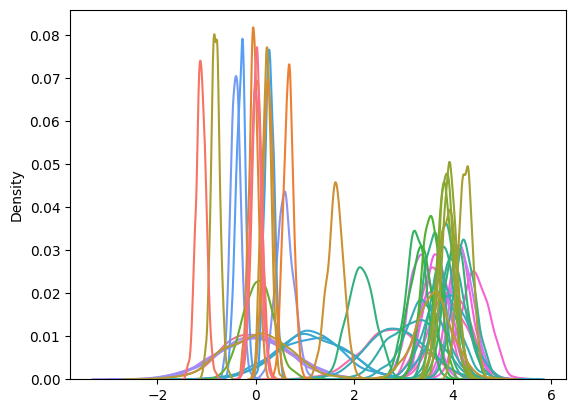

In [33]:
sns.kdeplot(bias_samples)
plt.legend([],[], frameon=False)

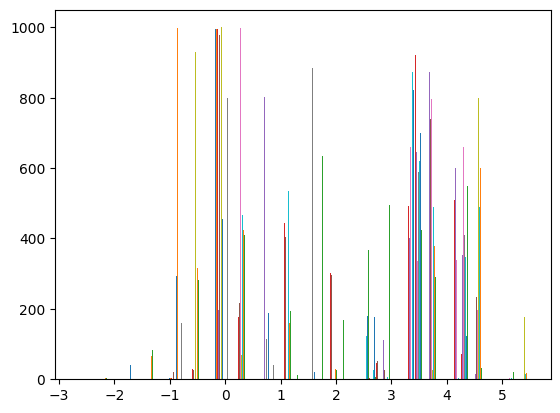

In [29]:
# Create histogram
plt.hist(bias_samples, bins=10)

# Show plot
plt.show()